# ASTrED playground

In [1]:
from detectors.syntax_sim import astredRunner, astredAndre

/home/andre/.pyenv/versions/3.10.11/envs/env_thesis_main/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Metrics

### Metric codes

#### Sacr Cross score

In [25]:
def sacr_cross_score(astred_obj, round_bool=False, round_num=2):
    ''''''
    # The final SACr value is the number of crossing alignment links between 
    # the source and target SACr groups, normalised by the number of these alignments. ~Vanroy et al.
    score = len(astred_obj.no_null_word_pairs) / astred_obj.src.sacr_cross
    if round_bool:
        return round(score, round_num)
    else:
        return score

#### Label Change Score

In [26]:
def label_changes_score(astred_obj, round_bool=False, round_num=2, verbose=False):
    ''''''
    # We look at each source word and compare its label 
    # to the labels of the words that it is aligned to.
    # These label changes are then normalised by 
    # the total number of alignments ~Vanroy et al.
    change_list = []
    for src, tgt in astred_obj.no_null_word_pairs:
        if src.deprel == tgt.deprel:
            change = 0
        else:
            change = 1
        change_list.append(change)
        if verbose:
            print(f'\'{src.text}\'({src.deprel}) | \'{tgt.text}\'({tgt.deprel}) | {change}')

    score = sum(change_list) / len(astred_obj.no_null_word_pairs)

    if round_bool:
        score = round(score, round_num)

    if verbose:
        print(f'Total: {sum(change_list)} (normalised: {sum(change_list)} out of {len(astred_obj.no_null_word_pairs)} = {score})')
    
    return score

#### ASTrED Score

In [27]:
from statistics import mean


def astred_score(astred_obj, en_sent, nl_sent, round_bool=False, round_num=2, verbose=False):
    ''''''
    # Use dependency trees with UD labels on grouped source-target tokens to retrieve 
    # the amount of steps necessary for both source and target trees to become the same as the other.
    # Normalised by taking the total scores of all trees by the average of source and target words.
    src_astred_score = []
    tgt_astred_score = []
    for src, tgt in astred_obj.no_null_word_pairs:
        src_astred_score.append(src.tree.astred_cost)
        tgt_astred_score.append(tgt.tree.astred_cost)
        if verbose:
            print(src.text, src.tree.astred_op, tgt.text, tgt.tree.astred_op)

    score = (
        (sum(src_astred_score) + sum(tgt_astred_score)) 
         / mean([len(en_sent.no_null_words), len(nl_sent.no_null_words)])
    )

    if round_bool:
        score = round(score, round_num)

    if verbose:
        print('')

    return score

### Example inputs

In [28]:
sent_dict = {
    'name': 'test_1',
    'en': 'Sometimes she asks me why I used to call her father Harold .',
    'nl': 'Soms vraagt ze waarom ik haar vader Harold noemde .',
    'aligns': '0-0 1-2 2-1 4-3 5-4 8-8 9-5 10-6 11-7 12-9',
}

astred_sacr = astredAndre(
    en=sent_dict['en'],
    nl=sent_dict['nl'],
    aligns=sent_dict['aligns'],
    name=sent_dict['name'],
)

In [30]:
sent_dict = {
    'name': 'test_2',
    'en': 'I saw him .',
    'nl': 'Hij werd door mij gezien .',
    'aligns': '0-2 0-3 1-1 1-4 2-0',
}

astred_label = astredAndre(
    en=sent_dict['en'],
    nl=sent_dict['nl'],
    aligns=sent_dict['aligns'],
    name=sent_dict['name'],
)

In [51]:
sent_dict = {
    'name': 'test_3',
    'en': 'Does he believe in love ?',
    'nl': 'Gelooft hij in de liefde ?',
    'aligns': '0-0 1-1 2-0 3-2 4-3 4-4 5-5',
}

astred_astred_score = astredAndre(
    en=sent_dict['en'],
    nl=sent_dict['nl'],
    aligns=sent_dict['aligns'],
    name=sent_dict['name'],
)

### Example metric outputs

In [81]:
sacr_cross_score(astred_sacr.aligned, round_bool=True)

3.33

In [83]:
label_changes_score(astred_label.aligned, verbose=True)

'I'(nsubj) | 'door'(case) | 1
'I'(nsubj) | 'mij'(obl) | 1
'saw'(root) | 'werd'(aux) | 1
'saw'(root) | 'gezien'(root) | 0
'him'(obj) | 'Hij'(nsubj) | 1
Total: 4 (normalised: 4 out of 5 = 0.8)


0.8

In [86]:
astred_score(astred_astred_score.aligned, astred_astred_score.sent_en, astred_astred_score.sent_nl)

0.3333333333333333

## General testing

In [3]:
import pandas as pd

# for src, tgt in astred.aligned.no_null_word_pairs:
#     print(src.text, tgt.text)

df = pd.DataFrame.from_dict({src.text: [sent_dict['name'], tgt.text, src.deprel, src.cross, src.sacr_group.cross, src.num_changes(), src.tree.astred_op]
                                 for src, tgt in astred.aligned.no_null_word_pairs},
        orient="index",
        columns=["sent_name", "aligned_tgt", "deprel", "cross", "sacr_cross", "dep_changes", "astred_op"])
# df = pd.DataFrame.from_dict({src.text: [tgt.text, 
#                                         src.deprel, tgt.deprel, 
#                                         src.cross, tgt.cross, 
#                                         src.sacr_group.cross, tgt.sacr_group.cross, 
#                                         src.num_changes(), tgt.num_changes(),
#                                         src.tree.astred_op, tgt.tree.astred_op]
#                                  for src, tgt in astred.aligned.no_null_word_pairs},
#         orient="index",
#         columns=[
#             "aligned_tgt",
#             "deprel_src", "deprel_tgt", 
#             "cross_src", "cross_tgt",
#             "sacr_cross_src", "sacr_cross_tgt",
#             "dep_changes_src", "dep_changes_tgt", 
#             "astred_op_src", "astred_op_tgt"
#         ])
df.index.name = 'aligned_src'

display(df)

,sent_name,aligned_tgt,deprel,cross,sacr_cross,dep_changes,astred_op
aligned_src,,,,,,,
The,test_1,de,det,3,3,1,match
show,test_1,voorstelling,nsubj,4,4,1,deletion
is,test_1,is,aux,2,2,1,match
billed,test_1,is,root,2,2,1,rename
as,test_1,is,case,2,2,1,rename
the,test_1,het,det,3,3,0,match
museum,test_1,museum,nmod,3,3,1,match
's,test_1,in,case,4,3,0,deletion
largest,test_1,duurste,obl,4,3,1,deletion


In [26]:
df_grp = df.reset_index().groupby(['sent_name']).agg(list)

In [27]:
display(df_grp)

,aligned_src,aligned_tgt,deprel,cross,sacr_cross,dep_changes,astred_op
sent_name,,,,,,,
test_1,"[The, show, is, billed, as, the, museum, 's, l...","[de, voorstelling, is, is, is, het, museum, in...","[det, nsubj, aux, root, case, det, nmod, case,...","[3, 4, 2, 2, 2, 3, 3, 4, 4, 3, 0]","[3, 4, 2, 2, 2, 3, 3, 3, 3, 2, 0]","[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]","[match, deletion, match, rename, rename, match..."


In [5]:
df_src, df_tgt = astred.data_frame()
display(df_src)
display(df_tgt)


 data_frame 



,deprel,cross,sacr_cross,dep_changes,astred_op
The,det,3,3,1,match
show,nsubj,4,4,1,deletion
is,aux,2,2,1,match
billed,root,2,2,1,rename
as,case,2,2,1,rename
the,det,3,3,0,match
museum,nmod,3,3,1,match
's,case,4,3,0,deletion
largest,obl,4,3,1,deletion
ever,advmod,3,2,0,deletion


,deprel,cross,sacr_cross,dep_changes,astred_op
Dit,nsubj,0,0,1,match
is,cop,6,6,3,match
de,det,3,3,0,rename
duurste,amod,4,3,1,deletion
voorstelling,root,4,4,1,rename
ooit,advmod,3,2,0,deletion
in,case,4,3,0,deletion
het,det,3,3,0,match
museum,obl,3,3,1,match
.,punct,0,0,0,match


In [6]:
astred.simple_analysis()
astred.is_changed()
astred.span_root()


 simple_analysis 

Dit The nsubj det
is is cop aux
is billed cop root
is as cop case
de The det det
duurste largest amod obl
voorstelling show root nsubj
ooit ever advmod advmod
in 's case case
het the det det
museum museum obl nmod
. . punct punct

 is_changed 

Dutch: is AUX
Aligned: is AUX False
Aligned: billed VERB True
Aligned: as ADP True

 span_root 

The The
show show
is is
billed billed
as as
the museum museum
's 's
largest largest
ever ever
. .


# Equal size samples

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

## Human

In [2]:
context_data = pd.read_csv('../results/context_data.tsv', sep='\t', index_col=0)

In [3]:
context_data_sents = context_data.drop_duplicates(subset=['sent_idx', 'film'])

In [4]:
context_data_sents.loc[:, 'src_sent_len'] = context_data_sents['src_sent'].apply(lambda x : len(x.split(' ')))
context_data_sents.loc[:, 'src_sent_len_nor'] = StandardScaler().fit_transform(context_data_sents[['src_sent_len']])
context_data_sents_norm = context_data_sents[(context_data_sents.src_sent_len_nor >= -1) & (context_data_sents.src_sent_len_nor <= 1)]

/tmp/ipykernel_2328/3330188286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_data_sents.loc[:, 'src_sent_len'] = context_data_sents['src_sent'].apply(lambda x : len(x.split(' ')))
/tmp/ipykernel_2328/3330188286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_data_sents.loc[:, 'src_sent_len_nor'] = StandardScaler().fit_transform(context_data_sents[['src_sent_len']])


In [5]:
context_data_sents_norm.loc[:, 'tgt_sent_len'] = context_data_sents_norm['tgt_sent'].apply(lambda x : len(x.split(' ')))
context_data_sents_norm.loc[:, 'tgt_sent_len_nor'] = StandardScaler().fit_transform(context_data_sents_norm[['tgt_sent_len']])
context_data_sents_norm = context_data_sents_norm[(context_data_sents_norm.tgt_sent_len_nor >= -1) 
                                                  & (context_data_sents_norm.tgt_sent_len_nor <= 1)]

/tmp/ipykernel_2328/2139194849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_data_sents_norm.loc[:, 'tgt_sent_len'] = context_data_sents_norm['tgt_sent'].apply(lambda x : len(x.split(' ')))
/tmp/ipykernel_2328/2139194849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_data_sents_norm.loc[:, 'tgt_sent_len_nor'] = StandardScaler().fit_transform(context_data_sents_norm[['tgt_sent_len']])


### Gold

In [7]:
for idx, film in enumerate(context_data_sents_norm['film'].unique()):
    samples = context_data_sents_norm[context_data_sents_norm.film == film].sample(2, random_state=1234)
    if idx == 0:
        sample_data = samples
    else:
        sample_data = pd.concat([sample_data, samples])

In [8]:
sample_data.drop([
    'src', 'tgt', 'cosine_w', 'src_sent_len', 
    'src_sent_len_nor', 'tgt_sent_len', 'tgt_sent_len_nor',
    'file', 'labels'
], axis=1, inplace=True)
sample_data.reset_index(inplace=True, drop=True)

In [9]:
sample_data = sample_data[['genre', 'film', 'sent_idx', 'src_sent', 'tgt_sent', 'aligns', 'cosine_sent']]
sample_data.rename(columns={'cosine_sent': 'context_cos_sent'}, inplace=True)
display(sample_data)

,genre,film,sent_idx,src_sent,tgt_sent,aligns,context_cos_sent
0,Action,AC01,262,The man might prove to have some noble blood i...,Misschien bewijst hij nog dat hij nobel bloed ...,3-1 4-4 5-8 7-6 8-7 10-5 11-3 12-9,0.220071
1,Action,AC01,11,"Protest , dissent , our right to think for our...","Protesten , opstand , het recht om zelf te denken",0-0 1-1 3-3 4-4 5-5 6-6 6-8 7-9,0.138292
2,Action,AC02,129,What ? She is perfect for you .,Wat ? Ze is perfect voor jou .,0-0 1-1 2-2 3-3 4-4 5-5 6-6 7-7,0.095637
3,Action,AC02,1125,Mike ! Let that be a lesson to your witch ass .,"Laat dat een lesje voor je zijn , heks .",0-8 2-0 3-1 5-2 6-3 7-4 8-5 11-9,0.597148
4,Action,AC03,88,"Oh , and on the off chance there are any astro...",Voor het geval jullie aanleg voor astronomie h...,3-0 4-1 6-2 8-7 10-6 11-4 13-8,0.366870
...,...,...,...,...,...,...,...
95,Drama,DR08,1014,I 've learnt that .,Dat heb ik geleerd .,0-2 1-1 2-3 3-0 4-4,0.074812
96,Drama,DR09,1293,"And let 's not forget , John Coffey is a murde...",En John Coffey is een moordenaar .,0-0 6-1 7-2 8-3 9-4 10-5 11-6,0.135627
97,Drama,DR09,1855,I lie in bed most nights thinking about it .,'s Nachts denk ik er veel aan in bed.,0-3 1-2 2-7 3-8 4-0 4-5 5-1 6-5 7-6 8-4 9-8,0.236759
98,Drama,DR10,276,We can reference the K - 23 beacon as our star...,We gebruiken het K-23-baken als startpunt .,0-0 2-1 3-2 4-3 5-3 6-3 7-3 8-4 10-5 11-5 12-6,0.261186


In [10]:
sample_data.to_csv('../data/2_new_run/sentence_gold_no-hu-labels' + '.tsv', sep='\t')

### Normal

In [6]:
for idx, film in enumerate(context_data_sents_norm['film'].unique()):
    samples = context_data_sents_norm[context_data_sents_norm.film == film].sample(20, random_state=1234)
    samples = samples[2:]
    if idx == 0:
        sample_data = samples
    else:
        sample_data = pd.concat([sample_data, samples])

In [7]:
sample_data.drop([
    'src', 'tgt', 'cosine_w', 'src_sent_len', 
    'src_sent_len_nor', 'tgt_sent_len', 'tgt_sent_len_nor',
    'file', 'labels'
], axis=1, inplace=True)
sample_data.reset_index(inplace=True, drop=True)

In [8]:
sample_data = sample_data[['genre', 'film', 'sent_idx', 'src_sent', 'tgt_sent', 'aligns', 'cosine_sent']]
sample_data.rename(columns={'cosine_sent': 'context_cos_sent'}, inplace=True)
display(sample_data)

,genre,film,sent_idx,src_sent,tgt_sent,aligns,context_cos_sent
0,Action,AC01,577,We both know what happens next .,We weten wat er hierna komt .,0-0 2-1 3-2 4-3 4-5 5-4 5-5 6-6,0.372022
1,Action,AC01,350,"I 'm gonna die in here , are n't I ? No .","Ik ga hier dood , hè ?",0-0 3-2 6-4 10-6,0.172147
2,Action,AC01,480,to our one Templar rule .,aan de wet van de Tempeliers .,0-0 1-1 3-5 4-2 5-6,0.512259
3,Action,AC01,184,Stand down . I have this .,Ik heb 't onder controle .,3-0 4-1 5-4 6-5,0.679190
4,Action,AC01,298,Then we should stop him before he betrays us .,We moeten hem tegenhouden voordat hij ons verr...,1-0 2-1 3-3 4-2 5-4 6-5 7-7 8-6 9-8,0.111248
...,...,...,...,...,...,...,...
895,Drama,DR10,208,It 's all right . You have to .,Het is goed . Het moet .,0-0 1-1 3-2 4-3 7-5 8-6,0.269485
896,Drama,DR10,451,Good . As long as one of us is .,Mooi . Zolang een van ons het maar weet .,0-0 1-1 3-2 4-2 5-3 6-4 7-5 8-8 9-9,0.310777
897,Drama,DR10,287,"Well , we know there was meteor activity here ,",We weten dat er meteorietenactiviteit is .,1-2 2-0 3-1 4-3 5-5 6-4 7-4 9-6,0.206883
898,Drama,DR10,657,"Flight Engineer Maya Lawrence , she suffered a...",Boordwerktuigkundige Maya Lawrence is verongel...,0-0 1-0 2-1 3-2 6-4 8-4 9-5 10-6 11-7 12-8,0.208300


In [9]:
sample_data.to_csv('../data/2_new_run/sentence_data' + '.tsv', sep='\t')

## Machine

In [10]:
context_data = pd.read_csv('../results/machine_context_data.tsv', sep='\t', index_col=0)

In [11]:
context_data_sents = context_data.drop_duplicates(subset=['sent_idx', 'film'])

In [12]:
context_data_sents.loc[:, 'src_sent_len'] = context_data_sents['src_sent'].apply(lambda x : len(x.split(' ')))
context_data_sents.loc[:, 'src_sent_len_nor'] = StandardScaler().fit_transform(context_data_sents[['src_sent_len']])
context_data_sents_norm = context_data_sents[(context_data_sents.src_sent_len_nor >= -1) & (context_data_sents.src_sent_len_nor <= 1)]

/tmp/ipykernel_2328/3330188286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_data_sents.loc[:, 'src_sent_len'] = context_data_sents['src_sent'].apply(lambda x : len(x.split(' ')))
/tmp/ipykernel_2328/3330188286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_data_sents.loc[:, 'src_sent_len_nor'] = StandardScaler().fit_transform(context_data_sents[['src_sent_len']])


In [13]:
context_data_sents_norm.loc[:, 'tgt_sent_len'] = context_data_sents_norm['tgt_sent'].apply(lambda x : len(x.split(' ')))
context_data_sents_norm.loc[:, 'tgt_sent_len_nor'] = StandardScaler().fit_transform(context_data_sents_norm[['tgt_sent_len']])
context_data_sents_norm = context_data_sents_norm[(context_data_sents_norm.tgt_sent_len_nor >= -1) 
                                                  & (context_data_sents_norm.tgt_sent_len_nor <= 1)]

/tmp/ipykernel_2328/2139194849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_data_sents_norm.loc[:, 'tgt_sent_len'] = context_data_sents_norm['tgt_sent'].apply(lambda x : len(x.split(' ')))
/tmp/ipykernel_2328/2139194849.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context_data_sents_norm.loc[:, 'tgt_sent_len_nor'] = StandardScaler().fit_transform(context_data_sents_norm[['tgt_sent_len']])


### Gold

In [26]:
for idx, film in enumerate(context_data_sents_norm['film'].unique()):
    samples = context_data_sents_norm[context_data_sents_norm.film == film].sample(2, random_state=1234)
    if idx == 0:
        sample_data = samples
    else:
        sample_data = pd.concat([sample_data, samples])

In [27]:
sample_data.drop([
    'src', 'tgt', 'cosine_w', 'src_sent_len', 
    'src_sent_len_nor', 'tgt_sent_len', 'tgt_sent_len_nor',
    'file', 'labels'
], axis=1, inplace=True)
sample_data.reset_index(inplace=True, drop=True)

In [28]:
sample_data = sample_data[['genre', 'film', 'sent_idx', 'src_sent', 'tgt_sent', 'aligns', 'cosine_sent']]
sample_data.rename(columns={'cosine_sent': 'context_cos_sent'}, inplace=True)
display(sample_data)

,genre,film,sent_idx,src_sent,tgt_sent,aligns,context_cos_sent
0,Action,AC01,539,It looks like a military port .,Het lijkt op een militaire haven .,0-0 1-1 2-2 3-3 4-4 5-5 6-6,0.085591
1,Action,AC01,262,or we do something about it .,of we doen er iets aan .,0-0 1-1 2-2 3-4 5-3 6-6,0.132636
2,Action,AC02,931,This is one last time .,Dit is een laatste keer .,0-0 1-1 2-2 3-3 4-4 5-5,0.043784
3,Action,AC02,671,"on a limb , fat as hell Right .","op een ledemaat , dik als de hel Juist .",0-0 1-1 2-2 3-3 4-4 5-5 6-7 7-8 8-9,0.261253
4,Action,AC03,1284,Show Dr. Schultz your back here . Go on .,Laat Dr. Schultz je rug zien . Ga maar .,0-0 1-1 2-2 3-3 4-4 5-5 6-6 7-7 8-8 9-9,0.085901
...,...,...,...,...,...,...,...
95,Drama,DR08,1099,"Apparently , there 's a whole convoy",Blijkbaar is er een heel konvooi ...,0-0 2-2 3-1 4-3 5-4 6-5,0.562293
96,Drama,DR09,526,"Always . You , Percy .","Altijd . Jij , Percy .",0-0 1-1 2-2 3-3 4-4 5-5,0.078572
97,Drama,DR09,981,I think you sweet on old Billy the Kid .,Ik denk dat je Billy de Kid leuk vindt .,0-0 1-1 5-3 6-4 7-5 8-6 9-9,0.191900
98,Drama,DR10,175,that the fault lies with us .,dat de fout bij ons ligt .,0-0 1-1 2-2 3-5 4-3 5-4 6-6,0.240660


In [29]:
sample_data.to_csv('../data/2_new_run/machine_sentence_gold_no-hu-labels' + '.tsv', sep='\t')

### Normal

In [14]:
for idx, film in enumerate(context_data_sents_norm['film'].unique()):
    samples = context_data_sents_norm[context_data_sents_norm.film == film].sample(20, random_state=1234)
    samples = samples[2:]
    if idx == 0:
        sample_data = samples
    else:
        sample_data = pd.concat([sample_data, samples])

In [15]:
sample_data.drop([
    'src', 'tgt', 'cosine_w', 'src_sent_len', 
    'src_sent_len_nor', 'tgt_sent_len', 'tgt_sent_len_nor',
    'file', 'labels'
], axis=1, inplace=True)
sample_data.reset_index(inplace=True, drop=True)

In [16]:
sample_data = sample_data[['genre', 'film', 'sent_idx', 'src_sent', 'tgt_sent', 'aligns', 'cosine_sent']]
sample_data.rename(columns={'cosine_sent': 'context_cos_sent'}, inplace=True)
display(sample_data)

,genre,film,sent_idx,src_sent,tgt_sent,aligns,context_cos_sent
0,Action,AC01,421,We need the Apple .,We hebben de appel nodig .,0-0 1-1 2-2 3-3 4-5,0.136107
1,Action,AC01,420,I 'm here to make a deal .,Ik ben hier om een deal te maken .,0-0 1-1 2-2 3-3 4-7 5-4 6-5 7-8,0.061843
2,Action,AC01,626,All I have to do is shout .,Ik hoef alleen maar te schreeuwen .,0-2 1-0 2-1 3-4 4-2 6-5 7-6,0.296828
3,Action,AC01,385,Not if you go in there of your own free will .,Niet als je uit vrije wil naar binnen gaat .,0-0 1-1 2-2 3-8 4-6 5-7 6-3 9-4 10-5 11-9,0.179202
4,Action,AC01,556,Breach in the common room !,Breuk in de gemeenschappelijke ruimte !,0-0 1-1 2-2 3-3 4-4 5-5,0.220899
...,...,...,...,...,...,...,...
895,Drama,DR10,232,So the air might still be good .,Dus de lucht is misschien nog goed .,0-0 1-1 2-2 4-5 6-6 7-7,0.091308
896,Drama,DR10,108,"I mean , it could be atmospheric ,","Ik bedoel , het kan atmosferisch zijn ,",0-0 1-1 2-2 3-3 4-4 5-6 6-5 7-7,0.138973
897,Drama,DR10,790,"First weeks we were there ,","De eerste weken dat we er waren ,",0-1 1-2 2-4 3-6 4-5 5-7,0.071402
898,Drama,DR10,767,I thought maybe I could help someone .,Ik dacht dat ik misschien iemand kon helpen .,0-0 1-1 2-4 3-3 4-6 5-7 6-5 7-8,0.036275


In [17]:
sample_data.to_csv('../data/2_new_run/machine_sentence_data' + '.tsv', sep='\t')

# Run astred

## code

In [ ]:
from detectors.syntax_sim import astredAndre
from collections import defaultdict
import json
from alive_progress import alive_bar
import pandas as pd

In [ ]:
def syntax_gen(syntax_data:str, gold:bool=True, mt:bool=False) -> None:
    if mt:
        out_pre = '../results/machine_'
    else:
        out_pre = '../results/'

    if gold:
        json_out = out_pre + 'syntax_data.json'
        tsv_out = out_pre + 'syntax_data_input.tsv'
    else:
        json_out = out_pre + 'syntax_data_normal.json'
        tsv_out = out_pre + 'syntax_data_normal_input.tsv'


    syntax_data = pd.read_csv(syntax_data, sep='\t', index_col=0)

    syntax_data_scores = defaultdict(dict)
    with alive_bar(len(syntax_data)) as bar:
        for row in syntax_data.itertuples():
            astred = astredAndre(row.src_sent, row.tgt_sent, row.aligns, row.Index)

            syntax_data_scores[row.Index]['sacr_cross_score'] = astred.sacr_cross_score(True, 3)
            syntax_data_scores[row.Index]['label_changes'] = astred.label_changes_score(True, 3)
            syntax_data_scores[row.Index]['astred_score'] = astred.astred_score(True, 3)
            syntax_data_scores[row.Index]['word_df'] = astred.data_frame().to_dict(orient='records')
            syntax_data_scores[row.Index]['film'] = row.film
            syntax_data_scores[row.Index]['sent_idx'] = row.sent_idx
            syntax_data_scores[row.Index]['src'] = row.src_sent
            syntax_data_scores[row.Index]['tgt'] = row.tgt_sent
            syntax_data_scores[row.Index]['aligns'] = row.aligns

            bar()

    with open(json_out, "w") as json_file:
        json.dump(syntax_data_scores, json_file)
        
    syntax_data_scores = {int(key): value for key, value in syntax_data_scores.items()}
    syntax_data_df = syntax_data.copy()
    for i in range(len(syntax_data_df)):
        syntax_data_df.at[i, 'sacr_cross_score'] = syntax_data_scores[i]['sacr_cross_score']
        syntax_data_df.at[i, 'label_changes'] = syntax_data_scores[i]['label_changes']
        syntax_data_df.at[i, 'astred_score'] = syntax_data_scores[i]['astred_score']

    syntax_data_df.to_csv(tsv_out, sep='\t')
    
    display(syntax_data_df.head())


## Human

### Gold

In [55]:
syntax_gen('../data/2_new_run/sentence_gold_labeled.tsv', gold=True, mt=False)

### Normal

In [ ]:
syntax_gen('../data/2_new_run/sentence_data.tsv', gold=False, mt=False)

## Machine

### Gold

In [ ]:
syntax_gen('../data/2_new_run/machine_sentence_gold_labeled.tsv', gold=True, mt=True)

### Normal

In [ ]:
syntax_gen('../data/2_new_run/machine_sentence_data.tsv', gold=False, mt=True)

# Analysis

## Imports

In [2]:
import pandas as pd
from statistics import mean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import classification_report

## General

### F1-score with Best threshold (Taken from Treshold testing)

#### Human

In [3]:
thresholds = pd.read_csv('../results/syntax_thresholds.tsv', sep='\t', index_col=0)
display(thresholds.style.highlight_max(subset=['f1-score'], color = 'mediumseagreen', axis = 0))

,threshold,precision,recall,f1-score,support,t_metric
0,0.400000,0.512733,0.514286,0.509804,100,sacr_cross_label
1,0.400000,0.604039,0.621429,0.600906,100,label_label
2,0.400000,0.552083,0.561905,0.537621,100,astred_label
3,0.450000,0.512733,0.514286,0.509804,100,sacr_cross_label
4,0.450000,0.583333,0.595238,0.582418,100,label_label
5,0.450000,0.536526,0.542857,0.528100,100,astred_label
6,0.500000,0.512733,0.514286,0.509804,100,sacr_cross_label
7,0.500000,0.643986,0.621429,0.627776,100,label_label
8,0.500000,0.591146,0.600000,0.592944,100,astred_label
9,0.550000,0.519305,0.521429,0.517450,100,sacr_cross_label


In [4]:
print(thresholds.to_latex(float_format="%.2f").replace('_', ' '))

\begin{tabular}{lrrrrrl}
\toprule
 & threshold & precision & recall & f1-score & support & t metric \\
\midrule
0 & 0.40 & 0.51 & 0.51 & 0.51 & 100 & sacr cross label \\
1 & 0.40 & 0.60 & 0.62 & 0.60 & 100 & label label \\
2 & 0.40 & 0.55 & 0.56 & 0.54 & 100 & astred label \\
3 & 0.45 & 0.51 & 0.51 & 0.51 & 100 & sacr cross label \\
4 & 0.45 & 0.58 & 0.60 & 0.58 & 100 & label label \\
5 & 0.45 & 0.54 & 0.54 & 0.53 & 100 & astred label \\
6 & 0.50 & 0.51 & 0.51 & 0.51 & 100 & sacr cross label \\
7 & 0.50 & 0.64 & 0.62 & 0.63 & 100 & label label \\
8 & 0.50 & 0.59 & 0.60 & 0.59 & 100 & astred label \\
9 & 0.55 & 0.52 & 0.52 & 0.52 & 100 & sacr cross label \\
10 & 0.55 & 0.66 & 0.63 & 0.64 & 100 & label label \\
11 & 0.55 & 0.59 & 0.60 & 0.59 & 100 & astred label \\
12 & 0.60 & 0.52 & 0.52 & 0.52 & 100 & sacr cross label \\
13 & 0.60 & 0.67 & 0.57 & 0.56 & 100 & label label \\
14 & 0.60 & 0.52 & 0.52 & 0.52 & 100 & astred label \\
\bottomrule
\end{tabular}



In [5]:
best_report = pd.read_csv('../results/syntax_best_thres_report.tsv', sep='\t', index_col=0)
print('Classification report')
print(best_report.to_string().replace('NaN', '   ').replace('accuracy', '\naccuracy'))

Classification report
                precision    recall  f1-score  support
creative shift   0.545455  0.400000  0.461538     30.0
reproduction     0.769231  0.857143  0.810811     70.0

accuracy                             0.720000    100.0
macro avg        0.657343  0.628571  0.636175    100.0
weighted avg     0.702098  0.720000  0.706029    100.0


In [6]:
print(best_report.to_latex(float_format="%.2f").replace('NaN', '   ').replace('accuracy', '\\\\\naccuracy'))

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
creative shift & 0.55 & 0.40 & 0.46 & 30.00 \\
reproduction & 0.77 & 0.86 & 0.81 & 70.00 \\
\\
accuracy &     &     & 0.72 & 100.00 \\
macro avg & 0.66 & 0.63 & 0.64 & 100.00 \\
weighted avg & 0.70 & 0.72 & 0.71 & 100.00 \\
\bottomrule
\end{tabular}



#### Machine

In [7]:
thresholds = pd.read_csv('../results/machine_syntax_thresholds.tsv', sep='\t', index_col=0)
display(thresholds.style.highlight_max(subset=['f1-score'], color = 'mediumseagreen', axis = 0))

,threshold,precision,recall,f1-score,support,t_metric
0,0.400000,0.512627,0.524621,0.493787,100,sacr_cross_label
1,0.400000,0.520499,0.543561,0.491813,100,label_label
2,0.400000,0.565062,0.638258,0.548278,100,astred_label
3,0.450000,0.512627,0.524621,0.493787,100,sacr_cross_label
4,0.450000,0.544647,0.583333,0.538143,100,label_label
5,0.450000,0.572610,0.649621,0.562937,100,astred_label
6,0.500000,0.512627,0.524621,0.493787,100,sacr_cross_label
7,0.500000,0.607869,0.615530,0.611429,100,label_label
8,0.500000,0.585478,0.666667,0.585826,100,astred_label
9,0.550000,0.512627,0.524621,0.493787,100,sacr_cross_label


In [8]:
print(thresholds.to_latex(float_format="%.2f").replace('_', ' '))

\begin{tabular}{lrrrrrl}
\toprule
 & threshold & precision & recall & f1-score & support & t metric \\
\midrule
0 & 0.40 & 0.51 & 0.52 & 0.49 & 100 & sacr cross label \\
1 & 0.40 & 0.52 & 0.54 & 0.49 & 100 & label label \\
2 & 0.40 & 0.57 & 0.64 & 0.55 & 100 & astred label \\
3 & 0.45 & 0.51 & 0.52 & 0.49 & 100 & sacr cross label \\
4 & 0.45 & 0.54 & 0.58 & 0.54 & 100 & label label \\
5 & 0.45 & 0.57 & 0.65 & 0.56 & 100 & astred label \\
6 & 0.50 & 0.51 & 0.52 & 0.49 & 100 & sacr cross label \\
7 & 0.50 & 0.61 & 0.62 & 0.61 & 100 & label label \\
8 & 0.50 & 0.59 & 0.67 & 0.59 & 100 & astred label \\
9 & 0.55 & 0.51 & 0.52 & 0.49 & 100 & sacr cross label \\
10 & 0.55 & 0.62 & 0.62 & 0.62 & 100 & label label \\
11 & 0.55 & 0.60 & 0.68 & 0.60 & 100 & astred label \\
12 & 0.60 & 0.51 & 0.52 & 0.49 & 100 & sacr cross label \\
13 & 0.60 & 0.75 & 0.61 & 0.65 & 100 & label label \\
14 & 0.60 & 0.60 & 0.66 & 0.61 & 100 & astred label \\
\bottomrule
\end{tabular}



In [9]:
best_report = pd.read_csv('../results/machine_syntax_best_thres_report.tsv', sep='\t', index_col=0)
print('Classification report')
print(best_report.to_string().replace('NaN', '   ').replace('accuracy', '\naccuracy'))

Classification report
                precision    recall  f1-score  support
creative shift   0.600000  0.250000  0.352941     12.0
reproduction     0.905263  0.977273  0.939891     88.0

accuracy                             0.890000    100.0
macro avg        0.752632  0.613636  0.646416    100.0
weighted avg     0.868632  0.890000  0.869457    100.0


In [10]:
print(best_report.to_latex(float_format="%.2f").replace('NaN', '   ').replace('accuracy', '\\\\\naccuracy'))

\begin{tabular}{lrrrr}
\toprule
 & precision & recall & f1-score & support \\
\midrule
creative shift & 0.60 & 0.25 & 0.35 & 12.00 \\
reproduction & 0.91 & 0.98 & 0.94 & 88.00 \\
\\
accuracy &     &     & 0.89 & 100.00 \\
macro avg & 0.75 & 0.61 & 0.65 & 100.00 \\
weighted avg & 0.87 & 0.89 & 0.87 & 100.00 \\
\bottomrule
\end{tabular}



## Overview Graph showing human and machine data label distribution

In [11]:
def label_normal(df, score_sys, best_thres):
    df['labels'] = df[score_sys].apply(lambda x: 'reproduction' if x < best_thres else 'creative shift')
    return df

In [12]:
data = pd.read_csv('../results/syntax_data_normal_input.tsv', sep='\t', index_col=0)
data_mt = pd.read_csv('../results/machine_syntax_data_normal_input.tsv', sep='\t', index_col=0)

# In case some duplicates were left in the data
# data.drop_duplicates(inplace=True)
# data_mt.drop_duplicates(inplace=True)

In [13]:
data = label_normal(data, 'label_changes', .55)
data_mt = label_normal(data_mt, 'label_changes', .6)

In [14]:
df_amount = defaultdict(list)
for genre in data.genre.unique():
    for key, value in data[data.genre == genre].labels.value_counts().to_dict().items():
        df_amount['Genre'].append(genre)
        df_amount['Repro/Shift'].append(key)
        df_amount['Number'].append(value)
df_amount = pd.DataFrame.from_dict(df_amount)

df_amount_mt = defaultdict(list)
for genre in data_mt.genre.unique():
    for key, value in data_mt[data_mt.genre == genre].labels.value_counts().to_dict().items():
        df_amount_mt['Genre'].append(genre)
        df_amount_mt['Repro/Shift'].append(key)
        df_amount_mt['Number'].append(value)
df_amount_mt = pd.DataFrame.from_dict(df_amount_mt)

In [15]:
df_amount.loc[2, 'Genre'] = 'children family'
df_amount.loc[3, 'Genre'] = 'children family'
df_amount_mt.loc[2, 'Genre'] = 'children family'
df_amount_mt.loc[3, 'Genre'] = 'children family'

In [16]:
display(df_amount, df_amount_mt)

,Genre,Repro/Shift,Number
0,Action,reproduction,141
1,Action,creative shift,39
2,children family,reproduction,141
3,children family,creative shift,39
4,Comedy,reproduction,136
5,Comedy,creative shift,44
6,Documentary,reproduction,146
7,Documentary,creative shift,34
8,Drama,reproduction,138
9,Drama,creative shift,42


,Genre,Repro/Shift,Number
0,Action,reproduction,163
1,Action,creative shift,17
2,children family,reproduction,171
3,children family,creative shift,9
4,Comedy,reproduction,166
5,Comedy,creative shift,14
6,Documentary,reproduction,171
7,Documentary,creative shift,9
8,Drama,reproduction,168
9,Drama,creative shift,12


In [17]:
display(df_amount.groupby(['Genre']).sum(), 
        df_amount_mt.groupby(['Genre']).sum())

,Repro/Shift,Number
Genre,,
Action,reproductioncreative shift,180
Comedy,reproductioncreative shift,180
Documentary,reproductioncreative shift,180
Drama,reproductioncreative shift,180
children family,reproductioncreative shift,180


,Repro/Shift,Number
Genre,,
Action,reproductioncreative shift,180
Comedy,reproductioncreative shift,180
Documentary,reproductioncreative shift,180
Drama,reproductioncreative shift,180
children family,reproductioncreative shift,180


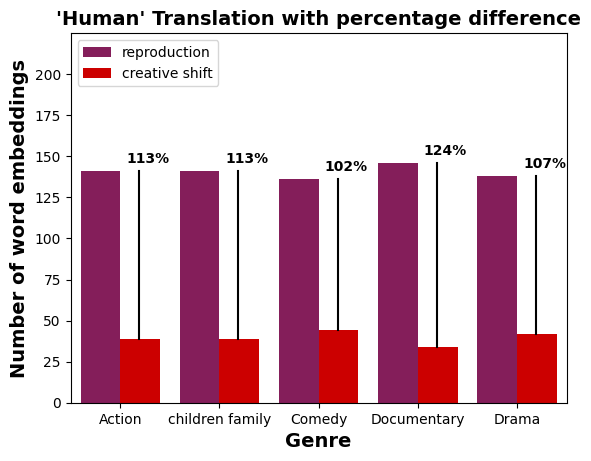

In [18]:

colors = ['#841e5a', '#cc0000']

t = sns.barplot(x = 'Genre', y = 'Number', hue = 'Repro/Shift', data = df_amount,
            # palette = 'hls',
            # palette = 'rocket',
            palette = colors,
            # order = ['male', 'female'],  
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            errorbar = 'sd'   
            )

start_loc = (0.19, .06)
# t_nor = lambda a : 1 / 63000 * a
t_nor = lambda a : 1 / 225 * a
per_diff = lambda a, b, c=None : round(((a - b) / mean([a, b])) * 100, c)

for idx, g in enumerate(df_amount.Genre.unique()):
    try:
        line_min = df_amount[(df_amount.Genre == g) & (df_amount['Repro/Shift'] == 'creative shift')].Number.sum()
        line_max = df_amount[(df_amount.Genre == g) & (df_amount['Repro/Shift'] == 'reproduction')].Number.sum()
        t.axvline(start_loc[0]+(1*idx), t_nor(line_min), t_nor(line_max), color='black')
        t.text(start_loc[1]+(1*idx), line_max+5, '{}%'.format(per_diff(line_max, line_min)), weight=600)
    except:
        print(line_min, line_max)
        print(idx, g)


t.set(ylim=(0, 225))
t.legend(loc="upper left")
# sns.move_legend(t, "upper left", bbox_to_anchor=(1, 1))
plt.yticks(range(0, 225, 25))
plt.title('\'Human\' Translation with percentage difference', size=14, weight=600)
plt.xlabel('Genre', size=14, weight=600)
plt.ylabel('Number of word embeddings', size=14, weight=600)
plt.show()

In [19]:
t.figure.savefig('../results/figures/syntax_human_barplot.pdf', format='pdf', bbox_inches="tight")

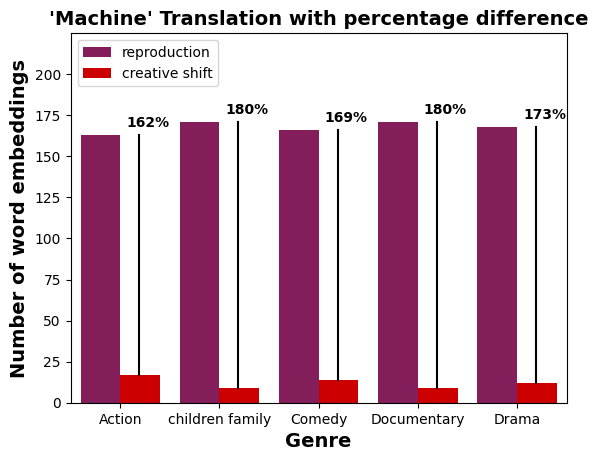

In [20]:
colors = ['#841e5a', '#cc0000']

t = sns.barplot(x = 'Genre', y = 'Number', hue = 'Repro/Shift', data = df_amount_mt,
            # palette = 'hls',
            # palette = 'rocket',
            palette = colors,
            # order = ['male', 'female'],  
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            errorbar = 'sd'   
            )

start_loc = (0.19, .06)
# t_nor = lambda a : 1 / 63000 * a
t_nor = lambda a : 1 / 225 * a
per_diff = lambda a, b, c=None : round(((a - b) / mean([a, b])) * 100, c)

for idx, g in enumerate(df_amount.Genre.unique()):
    line_min = df_amount_mt[(df_amount_mt.Genre == g) & (df_amount_mt['Repro/Shift'] == 'creative shift')].Number.sum()
    line_max = df_amount_mt[(df_amount_mt.Genre == g) & (df_amount_mt['Repro/Shift'] == 'reproduction')].Number.sum()
    t.axvline(start_loc[0]+(1*idx), t_nor(line_min), t_nor(line_max), color='black')
    t.text(start_loc[1]+(1*idx), line_max+5, '{}%'.format(per_diff(line_max, line_min)), weight=600)


t.set(ylim=(0, 225))
t.legend(loc="upper left")
# sns.move_legend(t, "upper left", bbox_to_anchor=(1, 1))
plt.yticks(range(0, 225, 25))
plt.title('\'Machine\' Translation with percentage difference', size=14, weight=600)
plt.xlabel('Genre', size=14, weight=600)
plt.ylabel('Number of word embeddings', size=14, weight=600)
plt.show()

In [21]:
t.figure.savefig('../results/figures/syntax_machine_barplot.pdf', format='pdf', bbox_inches="tight")

## Genres

### Code

In [22]:
def tex_formatter(tex_str):
    tex_lst = tex_str.split('\n')
    tex_lst[2] = tex_lst[2].replace(r'&', r'& \bf').replace(r'_', r' ')
    tex_str = '\n'.join(tex_lst)
    print(tex_str)


In [23]:
def genre_prep(gold, genre):
    genre = gold[gold.genre == genre]
    print(classification_report(genre.human_label, genre.labels))
    print('')
    
    action_thres = pd.DataFrame(classification_report(genre.human_label, genre.labels, output_dict=True)).T
    action_thres.loc['accuracy', 'precision'] = None
    action_thres.loc['accuracy', 'recall'] = None
    action_thres.loc['accuracy', 'support'] = action_thres.loc['macro avg', 'support']
    tex_str = action_thres.to_latex(float_format='%.2f').replace('NaN', '   ')
    tex_lst = tex_str.split('\n')
    tex_lst[2] = tex_lst[2].replace(r'&', r'& \bf')
    tex_str = '\n'.join(tex_lst)
    print(tex_str)
    return genre

In [24]:
def label_normal(df, score_sys, best_thres):
    df[f'labels'] = df[score_sys].apply(lambda x: 'creative shift' if x > best_thres else 'reproduction')
    return df

### Human

In [25]:
gold_metric = 'label_changes'
gold = pd.read_csv('../results/syntax_data_input.tsv', sep='\t', index_col=0)
gold = label_normal(gold, gold_metric, .55)

In [26]:
gold = gold[['genre', 'film', 'sent_idx', 'src_sent', 'tgt_sent', gold_metric, 'human_label', 'labels']]
gold.genre = gold.genre.map(lambda x : x.lower())
gold.human_label = gold.human_label.map(lambda x : x.lower())
gold

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
0,action,AC01,262,The man might prove to have some noble blood i...,Misschien bewijst hij nog dat hij nobel bloed ...,0.250,reproduction,reproduction
1,action,AC01,11,"Protest , dissent , our right to think for our...","Protesten , opstand , het recht om zelf te denken",0.250,reproduction,reproduction
2,action,AC02,129,What ? She is perfect for you .,Wat ? Ze is perfect voor jou .,0.125,reproduction,reproduction
3,action,AC02,1125,Mike ! Let that be a lesson to your witch ass .,"Laat dat een lesje voor je zijn , heks .",0.375,creative shift,reproduction
4,action,AC03,88,"Oh , and on the off chance there are any astro...",Voor het geval jullie aanleg voor astronomie h...,0.857,creative shift,creative shift
...,...,...,...,...,...,...,...,...
95,drama,DR08,1014,I 've learnt that .,Dat heb ik geleerd .,0.000,reproduction,reproduction
96,drama,DR09,1293,"And let 's not forget , John Coffey is a murde...",En John Coffey is een moordenaar .,0.286,reproduction,reproduction
97,drama,DR09,1855,I lie in bed most nights thinking about it .,'s Nachts denk ik er veel aan in bed.,0.455,reproduction,reproduction
98,drama,DR10,276,We can reference the K - 23 beacon as our star...,We gebruiken het K-23-baken als startpunt .,0.545,reproduction,reproduction


#### Action

In [27]:
action = genre_prep(gold, 'action')

                precision    recall  f1-score   support

creative shift       0.60      0.38      0.46         8
  reproduction       0.67      0.83      0.74        12

      accuracy                           0.65        20
     macro avg       0.63      0.60      0.60        20
  weighted avg       0.64      0.65      0.63        20


\begin{tabular}{lrrrr}
\toprule
 & \bf precision & \bf recall & \bf f1-score & \bf support \\
\midrule
creative shift & 0.60 & 0.38 & 0.46 & 8.00 \\
reproduction & 0.67 & 0.83 & 0.74 & 12.00 \\
accuracy &     &     & 0.65 & 20.00 \\
macro avg & 0.63 & 0.60 & 0.60 & 20.00 \\
weighted avg & 0.64 & 0.65 & 0.63 & 20.00 \\
\bottomrule
\end{tabular}



In [28]:
action.style.apply(lambda x: ['color:red' if x['labels']!=x['human_label'] else 'color:green']*len(x), axis=1)

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
0,action,AC01,262,The man might prove to have some noble blood in him yet .,Misschien bewijst hij nog dat hij nobel bloed heeft .,0.250000,reproduction,reproduction
1,action,AC01,11,"Protest , dissent , our right to think for ourselves","Protesten , opstand , het recht om zelf te denken",0.250000,reproduction,reproduction
2,action,AC02,129,What ? She is perfect for you .,Wat ? Ze is perfect voor jou .,0.125000,reproduction,reproduction
3,action,AC02,1125,Mike ! Let that be a lesson to your witch ass .,"Laat dat een lesje voor je zijn , heks .",0.375000,creative shift,reproduction
4,action,AC03,88,"Oh , and on the off chance there are any astronomy aficionados amongst you",Voor het geval jullie aanleg voor astronomie hebben :,0.857000,creative shift,creative shift
5,action,AC03,716,I 've heard tell about you .,Ik heb verhalen over je gehoord .,0.333000,creative shift,reproduction
6,action,AC04,469,And I 'd feel sick .,En dan word ik misselijk .,0.500000,reproduction,reproduction
7,action,AC04,161,You need to be smart . Use your wits .,Je moet slim zijn . Gebruik je verstand .,0.333000,reproduction,reproduction
8,action,AC05,660,"Put Brody in the tank . Well , in this sun ,",Zet Brody in de tank .,0.000000,reproduction,reproduction
9,action,AC05,396,"Look , can we discuss this later ?","Ja , dus . Kan dit een andere keer ?",0.571000,creative shift,creative shift


In [29]:
pd.options.mode.chained_assignment = None
display(action[action.labels != action.human_label].drop(columns=['genre', 'sent_idx']))
action['human_label'] = action['human_label'].map({'reproduction': 'R', 'creative shift': 'CS'})
action['labels'] = action['labels'].map({'reproduction': 'R', 'creative shift': 'CS'})
tex_formatter(action[action.labels != action.human_label].drop(columns=['genre', 'sent_idx']).to_latex(float_format="%.3f"))
pd.options.mode.chained_assignment = 'warn'

,film,src_sent,tgt_sent,label_changes,human_label,labels
3,AC02,Mike ! Let that be a lesson to your witch ass .,"Laat dat een lesje voor je zijn , heks .",0.375,creative shift,reproduction
5,AC03,I 've heard tell about you .,Ik heb verhalen over je gehoord .,0.333,creative shift,reproduction
11,AC06,Everything at last has been arranged . The Ark...,Alles is geregeld . En de Ark ?,0.143,creative shift,reproduction
15,AC08,Let 's see some identification .,Geef me je papieren eens .,0.400,creative shift,reproduction
16,AC09,BEFORE THEY BECAME OPERATIONAL . HE SAID YOU W...,"Jij was de eerste , zei hij .",0.167,creative shift,reproduction
18,AC10,We are usually a better judge of character .,We hebben normaal meer mensenkennis .,0.667,reproduction,creative shift
19,AC10,How many shooters on site ? At least 30 .,Hoeveel schutters zijn er ? Minstens 30.,0.857,reproduction,creative shift


\begin{tabular}{llllrll}
\toprule
 & \bf film & \bf src sent & \bf tgt sent & \bf label changes & \bf human label & \bf labels \\
\midrule
3 & AC02 & Mike ! Let that be a lesson to your witch ass . & Laat dat een lesje voor je zijn , heks . & 0.375 & CS & R \\
5 & AC03 & I 've heard tell about you . & Ik heb verhalen over je gehoord . & 0.333 & CS & R \\
11 & AC06 & Everything at last has been arranged . The Ark ? Is on board . & Alles is geregeld . En de Ark ? & 0.143 & CS & R \\
15 & AC08 & Let 's see some identification . & Geef me je papieren eens . & 0.400 & CS & R \\
16 & AC09 & BEFORE THEY BECAME OPERATIONAL . HE SAID YOU WERE THE FIRST ONE . & Jij was de eerste , zei hij . & 0.167 & CS & R \\
18 & AC10 & We are usually a better judge of character . & We hebben normaal meer mensenkennis . & 0.667 & R & CS \\
19 & AC10 & How many shooters on site ? At least 30 . & Hoeveel schutters zijn er ? Minstens 30. & 0.857 & R & CS \\
\bottomrule
\end{tabular}



#### Children Family

In [30]:
children_family = genre_prep(gold, 'children_family')

                precision    recall  f1-score   support

creative shift       0.75      0.43      0.55         7
  reproduction       0.75      0.92      0.83        13

      accuracy                           0.75        20
     macro avg       0.75      0.68      0.69        20
  weighted avg       0.75      0.75      0.73        20


\begin{tabular}{lrrrr}
\toprule
 & \bf precision & \bf recall & \bf f1-score & \bf support \\
\midrule
creative shift & 0.75 & 0.43 & 0.55 & 7.00 \\
reproduction & 0.75 & 0.92 & 0.83 & 13.00 \\
accuracy &     &     & 0.75 & 20.00 \\
macro avg & 0.75 & 0.68 & 0.69 & 20.00 \\
weighted avg & 0.75 & 0.75 & 0.73 & 20.00 \\
\bottomrule
\end{tabular}



In [31]:
children_family.style.apply(lambda x: ['color:red' if x['labels']!=x['human_label'] else 'color:green']*len(x), axis=1)

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
20,children_family,CH01,355,"Without it , well , Christmas simply",Zonder kerst Kerstmis moet blijven .,0.750000,creative shift,creative shift
21,children_family,CH01,1035,That 's my cue !,Dat is mijn signaal .,0.000000,reproduction,reproduction
22,children_family,CH02,11,Well I 'm about to change all of that .,Daar ga ik verandering in brengen .,0.600000,reproduction,creative shift
23,children_family,CH02,918,Looks like you guys had a visit from our old friend .,Zo te zien was dat onze oude vriend .,0.400000,creative shift,reproduction
24,children_family,CH03,138,"You know what you are , Lockwood ? No . A shenaniganizer .",Weet je wat je bent ? Een strekenpleger .,0.500000,reproduction,reproduction
25,children_family,CH03,747,I am also a comedian .,Ik ben ook komiek .,0.000000,reproduction,reproduction
26,children_family,CH04,363,"Paint your own picture , Enola .",Schilder je eigen schilderij .,0.250000,reproduction,reproduction
27,children_family,CH04,990,You may not think what I 'm doing is right .,Je denkt dat ik niet het juiste doe .,0.286000,creative shift,reproduction
28,children_family,CH05,970,I remember that now .,Nu weet ik het weer .,0.000000,reproduction,reproduction
29,children_family,CH05,128,"Oh , my gosh .","O , mijn God .",0.200000,reproduction,reproduction


In [32]:
pd.options.mode.chained_assignment = None
display(children_family[children_family.labels != children_family.human_label].drop(columns=['genre', 'sent_idx']))
children_family['human_label'] = children_family['human_label'].map({'reproduction': 'R', 'creative shift': 'CS'})
children_family['labels'] = children_family['labels'].map({'reproduction': 'R', 'creative shift': 'CS'})
tex_formatter(children_family[children_family.labels != children_family.human_label].drop(columns=['genre', 'sent_idx']).to_latex(float_format="%.3f"))
pd.options.mode.chained_assignment = 'warn'

,film,src_sent,tgt_sent,label_changes,human_label,labels
22,CH02,Well I 'm about to change all of that .,Daar ga ik verandering in brengen .,0.600,reproduction,creative shift
23,CH02,Looks like you guys had a visit from our old f...,Zo te zien was dat onze oude vriend .,0.400,creative shift,reproduction
27,CH04,You may not think what I 'm doing is right .,Je denkt dat ik niet het juiste doe .,0.286,creative shift,reproduction
32,CH07,That 's a lovely truck .,Wat een mooie wagen .,0.500,creative shift,reproduction
34,CH08,Pfft . Give me a break . When will they learn ?,Doe me een lol . Leren ze het nooit ?,0.300,creative shift,reproduction


\begin{tabular}{llllrll}
\toprule
 & \bf film & \bf src sent & \bf tgt sent & \bf label changes & \bf human label & \bf labels \\
\midrule
22 & CH02 & Well I 'm about to change all of that . & Daar ga ik verandering in brengen . & 0.600 & R & CS \\
23 & CH02 & Looks like you guys had a visit from our old friend . & Zo te zien was dat onze oude vriend . & 0.400 & CS & R \\
27 & CH04 & You may not think what I 'm doing is right . & Je denkt dat ik niet het juiste doe . & 0.286 & CS & R \\
32 & CH07 & That 's a lovely truck . & Wat een mooie wagen . & 0.500 & CS & R \\
34 & CH08 & Pfft . Give me a break . When will they learn ? & Doe me een lol . Leren ze het nooit ? & 0.300 & CS & R \\
\bottomrule
\end{tabular}



#### Comedy

In [33]:
comedy = genre_prep(gold, 'comedy')

                precision    recall  f1-score   support

creative shift       0.40      0.29      0.33         7
  reproduction       0.67      0.77      0.71        13

      accuracy                           0.60        20
     macro avg       0.53      0.53      0.52        20
  weighted avg       0.57      0.60      0.58        20


\begin{tabular}{lrrrr}
\toprule
 & \bf precision & \bf recall & \bf f1-score & \bf support \\
\midrule
creative shift & 0.40 & 0.29 & 0.33 & 7.00 \\
reproduction & 0.67 & 0.77 & 0.71 & 13.00 \\
accuracy &     &     & 0.60 & 20.00 \\
macro avg & 0.53 & 0.53 & 0.52 & 20.00 \\
weighted avg & 0.57 & 0.60 & 0.58 & 20.00 \\
\bottomrule
\end{tabular}



In [34]:
comedy.style.apply(lambda x: ['color:red' if x['labels']!=x['human_label'] else 'color:green']*len(x), axis=1)

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
40,comedy,CO01,1048,"Gosh , do n't you get it , Cal ? Your dad was right .",Snap je het niet ? Je vader had gelijk .,0.333000,reproduction,reproduction
41,comedy,CO01,324,"So , uh , here 's the deal .","Goed , het zit zo .",0.571000,creative shift,creative shift
42,comedy,CO02,816,"You 're gonna be okay . Wait , Kaylie !","Alles komt goed . Wacht , Kaylie .",0.500000,reproduction,reproduction
43,comedy,CO02,140,I 'm using my automatic out .,Ik gebruik mijn uitweg .,0.200000,creative shift,reproduction
44,comedy,CO03,725,and hand jobs at 12 .,aftrekken op je twaalfde . Bla bla bla.,0.500000,creative shift,reproduction
45,comedy,CO03,1233,Shit . Come on . The door .,Shit . Kom op . De deur .,0.250000,reproduction,reproduction
46,comedy,CO04,264,You guys will get through this rough patch .,Het komt wel weer goed .,0.500000,creative shift,reproduction
47,comedy,CO04,524,"Officer Steve , I saw my ne","Agent Steve , ik zag mijn",0.429000,reproduction,reproduction
48,comedy,CO05,1060,"Mr. Evans , in your own words , please ,",Vertel de rechtbank in uw eigen woorden,0.500000,creative shift,reproduction
49,comedy,CO05,339,Here ? Okay . Press down .,Hier ? Oké . Naar beneden .,0.571000,reproduction,creative shift


In [35]:
pd.options.mode.chained_assignment = None
display(comedy[comedy.labels != comedy.human_label].drop(columns=['genre', 'sent_idx']))
comedy['human_label'] = comedy['human_label'].map({'reproduction': 'R', 'creative shift': 'CS'})
comedy['labels'] = comedy['labels'].map({'reproduction': 'R', 'creative shift': 'CS'})
tex_formatter(comedy[comedy.labels != comedy.human_label].drop(columns=['genre', 'sent_idx']).to_latex(float_format="%.3f"))
pd.options.mode.chained_assignment = 'warn'

,film,src_sent,tgt_sent,label_changes,human_label,labels
43,CO02,I 'm using my automatic out .,Ik gebruik mijn uitweg .,0.200,creative shift,reproduction
44,CO03,and hand jobs at 12 .,aftrekken op je twaalfde . Bla bla bla.,0.500,creative shift,reproduction
46,CO04,You guys will get through this rough patch .,Het komt wel weer goed .,0.500,creative shift,reproduction
48,CO05,"Mr. Evans , in your own words , please ,",Vertel de rechtbank in uw eigen woorden,0.500,creative shift,reproduction
49,CO05,Here ? Okay . Press down .,Hier ? Oké . Naar beneden .,0.571,reproduction,creative shift
52,CO07,we 've got a target on our backs .,dat ze het op ons gemunt hebben .,0.250,creative shift,reproduction
56,CO09,Marriage is about love . It 's about being the...,Huwelijk gaat over liefde . En er zijn .,0.571,reproduction,creative shift
57,CO09,You fucking cheetah . My God .,Jij jachtluipaard . Mijn God .,0.571,reproduction,creative shift


\begin{tabular}{llllrll}
\toprule
 & \bf film & \bf src sent & \bf tgt sent & \bf label changes & \bf human label & \bf labels \\
\midrule
43 & CO02 & I 'm using my automatic out . & Ik gebruik mijn uitweg . & 0.200 & CS & R \\
44 & CO03 & and hand jobs at 12 . & aftrekken op je twaalfde . Bla bla bla. & 0.500 & CS & R \\
46 & CO04 & You guys will get through this rough patch . & Het komt wel weer goed . & 0.500 & CS & R \\
48 & CO05 & Mr. Evans , in your own words , please , & Vertel de rechtbank in uw eigen woorden & 0.500 & CS & R \\
49 & CO05 & Here ? Okay . Press down . & Hier ? Oké . Naar beneden . & 0.571 & R & CS \\
52 & CO07 & we 've got a target on our backs . & dat ze het op ons gemunt hebben . & 0.250 & CS & R \\
56 & CO09 & Marriage is about love . It 's about being there . & Huwelijk gaat over liefde . En er zijn . & 0.571 & R & CS \\
57 & CO09 & You fucking cheetah . My God . & Jij jachtluipaard . Mijn God . & 0.571 & R & CS \\
\bottomrule
\end{tabular}



#### Documentary

In [36]:
documentary = genre_prep(gold, 'documentary')

                precision    recall  f1-score   support

creative shift       0.25      1.00      0.40         1
  reproduction       1.00      0.84      0.91        19

      accuracy                           0.85        20
     macro avg       0.62      0.92      0.66        20
  weighted avg       0.96      0.85      0.89        20


\begin{tabular}{lrrrr}
\toprule
 & \bf precision & \bf recall & \bf f1-score & \bf support \\
\midrule
creative shift & 0.25 & 1.00 & 0.40 & 1.00 \\
reproduction & 1.00 & 0.84 & 0.91 & 19.00 \\
accuracy &     &     & 0.85 & 20.00 \\
macro avg & 0.62 & 0.92 & 0.66 & 20.00 \\
weighted avg & 0.96 & 0.85 & 0.89 & 20.00 \\
\bottomrule
\end{tabular}



In [37]:
documentary.style.apply(lambda x: ['color:red' if x['labels']!=x['human_label'] else 'color:green']*len(x), axis=1)

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
60,documentary,DO01,956,because their economic model needs that .,want hun economische model heeft dat nodig .,0.000000,reproduction,reproduction
61,documentary,DO01,1219,"The 13th Amendment says ,",Het 13e amendement zegt :,0.000000,reproduction,reproduction
62,documentary,DO02,179,"Right . Like , we had issues the other week",We hadden vorige week wat incidenten,0.000000,reproduction,reproduction
63,documentary,DO02,461,"or a new friendship has occurred , and you",of sluit je een nieuwe vriendschap die,0.600000,reproduction,creative shift
64,documentary,DO03,797,Now all you have to do is scan your face .,Je hoeft alleen je gezicht te scannen .,0.500000,reproduction,reproduction
65,documentary,DO03,519,talking about the same thing she was . On the search .,daarover praatte . Het zoeken .,0.750000,creative shift,creative shift
66,documentary,DO04,1077,to my community and to my people .,mijn gemeenschap en volk is aangedaan .,0.333000,reproduction,reproduction
67,documentary,DO04,1088,would rise up in disgust and horror,op zou staan in walging en afschuw,0.143000,reproduction,reproduction
68,documentary,DO05,177,It 's finite . It needs protecting .,Ze is eindig . Ze moet worden beschermd .,0.250000,reproduction,reproduction
69,documentary,DO05,318,"But if you get in a helicopter ,",Maar vanuit een helikopter zie je,0.400000,reproduction,reproduction


In [38]:
pd.options.mode.chained_assignment = None
display(documentary[documentary.labels != documentary.human_label].drop(columns=['genre', 'sent_idx']))
documentary['human_label'] = documentary['human_label'].map({'reproduction': 'R', 'creative shift': 'CS'})
documentary['labels'] = documentary['labels'].map({'reproduction': 'R', 'creative shift': 'CS'})
tex_formatter(documentary[documentary.labels != documentary.human_label].drop(columns=['genre', 'sent_idx']).to_latex(float_format="%.3f"))
pd.options.mode.chained_assignment = 'warn'

,film,src_sent,tgt_sent,label_changes,human_label,labels
63,DO02,"or a new friendship has occurred , and you",of sluit je een nieuwe vriendschap die,0.600,reproduction,creative shift
72,DO07,"Flip - flops , T - shirt , shorts .","Slippers , T-shirt , korte broek .",0.600,reproduction,creative shift
76,DO09,what the business model was gonna be for the c...,wat hun bedrijfsmodel moest worden .,0.875,reproduction,creative shift


\begin{tabular}{llllrll}
\toprule
 & \bf film & \bf src sent & \bf tgt sent & \bf label changes & \bf human label & \bf labels \\
\midrule
63 & DO02 & or a new friendship has occurred , and you & of sluit je een nieuwe vriendschap die & 0.600 & R & CS \\
72 & DO07 & Flip - flops , T - shirt , shorts . & Slippers , T-shirt , korte broek . & 0.600 & R & CS \\
76 & DO09 & what the business model was gonna be for the company . & wat hun bedrijfsmodel moest worden . & 0.875 & R & CS \\
\bottomrule
\end{tabular}



#### Drama

In [39]:
drama = genre_prep(gold, 'drama')

                precision    recall  f1-score   support

creative shift       0.75      0.43      0.55         7
  reproduction       0.75      0.92      0.83        13

      accuracy                           0.75        20
     macro avg       0.75      0.68      0.69        20
  weighted avg       0.75      0.75      0.73        20


\begin{tabular}{lrrrr}
\toprule
 & \bf precision & \bf recall & \bf f1-score & \bf support \\
\midrule
creative shift & 0.75 & 0.43 & 0.55 & 7.00 \\
reproduction & 0.75 & 0.92 & 0.83 & 13.00 \\
accuracy &     &     & 0.75 & 20.00 \\
macro avg & 0.75 & 0.68 & 0.69 & 20.00 \\
weighted avg & 0.75 & 0.75 & 0.73 & 20.00 \\
\bottomrule
\end{tabular}



In [40]:
drama.style.apply(lambda x: ['color:red' if x['labels']!=x['human_label'] else 'color:green']*len(x), axis=1)

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
80,drama,DR01,811,"Would n't you know it a few months later ,",En weet u wat ? Een paar maanden later,0.375000,reproduction,reproduction
81,drama,DR01,213,"Ma'am , you dropped your book . Ma'am","Mevrouw , uw boek .",0.400000,creative shift,reproduction
82,drama,DR02,294,before he went to California .,Voor hij naar Californië ging .,0.000000,reproduction,reproduction
83,drama,DR02,498,Wash out the damn blood .,Was het bloed eruit .,0.500000,reproduction,reproduction
84,drama,DR03,727,"Come on , I 'm jimmying it .","Kom op , ik piel toch ?",0.429000,creative shift,reproduction
85,drama,DR03,1132,Sometimes when we 're moving at night,Soms als we 's nachts verhuizen,0.857000,reproduction,creative shift
86,drama,DR04,437,What 's all this I hear about you not hunting ?,Klopt het dat je niet jaagt ?,0.375000,creative shift,reproduction
87,drama,DR04,923,They 'll believe it .,Ze zullen het geloven .,0.000000,reproduction,reproduction
88,drama,DR05,1129,"Sir , we have a situation .","Sir , dit is 'n situatie die misschien Onzin .",0.429000,creative shift,reproduction
89,drama,DR05,906,Anybody know a Ryan ?,Kent iemand een Ryan ?,0.200000,reproduction,reproduction


In [41]:
pd.options.mode.chained_assignment = None
display(drama[drama.labels != drama.human_label].drop(columns=['genre', 'sent_idx']))
drama['human_label'] = drama['human_label'].map({'reproduction': 'R', 'creative shift': 'CS'})
drama['labels'] = drama['labels'].map({'reproduction': 'R', 'creative shift': 'CS'})
tex_formatter(drama[drama.labels != drama.human_label].drop(columns=['genre', 'sent_idx']).to_latex(float_format="%.3f"))
pd.options.mode.chained_assignment = 'warn'

,film,src_sent,tgt_sent,label_changes,human_label,labels
81,DR01,"Ma'am , you dropped your book . Ma'am","Mevrouw , uw boek .",0.400,creative shift,reproduction
84,DR03,"Come on , I 'm jimmying it .","Kom op , ik piel toch ?",0.429,creative shift,reproduction
85,DR03,Sometimes when we 're moving at night,Soms als we 's nachts verhuizen,0.857,reproduction,creative shift
86,DR04,What 's all this I hear about you not hunting ?,Klopt het dat je niet jaagt ?,0.375,creative shift,reproduction
88,DR05,"Sir , we have a situation .","Sir , dit is 'n situatie die misschien Onzin .",0.429,creative shift,reproduction


\begin{tabular}{llllrll}
\toprule
 & \bf film & \bf src sent & \bf tgt sent & \bf label changes & \bf human label & \bf labels \\
\midrule
81 & DR01 & Ma'am , you dropped your book . Ma'am & Mevrouw , uw boek . & 0.400 & CS & R \\
84 & DR03 & Come on , I 'm jimmying it . & Kom op , ik piel toch ? & 0.429 & CS & R \\
85 & DR03 & Sometimes when we 're moving at night & Soms als we 's nachts verhuizen & 0.857 & R & CS \\
86 & DR04 & What 's all this I hear about you not hunting ? & Klopt het dat je niet jaagt ? & 0.375 & CS & R \\
88 & DR05 & Sir , we have a situation . & Sir , dit is 'n situatie die misschien Onzin . & 0.429 & CS & R \\
\bottomrule
\end{tabular}



### Machine

In [42]:
gold_metric = 'label_changes'
gold = pd.read_csv('../results/machine_syntax_data_input.tsv', sep='\t', index_col=0)
gold = label_normal(gold, gold_metric, .6)

In [43]:
gold = gold[['genre', 'film', 'sent_idx', 'src_sent', 'tgt_sent', gold_metric, 'human_label', 'labels']]
gold.genre = gold.genre.map(lambda x : x.lower())
gold.human_label = gold.human_label.map(lambda x : x.lower())
gold

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
0,action,AC01,539,It looks like a military port .,Het lijkt op een militaire haven .,0.000,reproduction,reproduction
1,action,AC01,262,or we do something about it .,of we doen er iets aan .,0.333,reproduction,reproduction
2,action,AC02,931,This is one last time .,Dit is een laatste keer .,0.333,reproduction,reproduction
3,action,AC02,671,"on a limb , fat as hell Right .","op een ledemaat , dik als de hel Juist .",0.556,reproduction,reproduction
4,action,AC03,1284,Show Dr. Schultz your back here . Go on .,Laat Dr. Schultz je rug zien . Ga maar .,0.200,reproduction,reproduction
...,...,...,...,...,...,...,...,...
95,drama,DR08,1099,"Apparently , there 's a whole convoy",Blijkbaar is er een heel konvooi ...,0.167,reproduction,reproduction
96,drama,DR09,526,"Always . You , Percy .","Altijd . Jij , Percy .",0.500,reproduction,reproduction
97,drama,DR09,981,I think you sweet on old Billy the Kid .,Ik denk dat je Billy de Kid leuk vindt .,0.571,reproduction,reproduction
98,drama,DR10,175,that the fault lies with us .,dat de fout bij ons ligt .,0.000,reproduction,reproduction


#### Action

In [44]:
action = genre_prep(gold, 'action')

                precision    recall  f1-score   support

creative shift       1.00      1.00      1.00         1
  reproduction       1.00      1.00      1.00        19

      accuracy                           1.00        20
     macro avg       1.00      1.00      1.00        20
  weighted avg       1.00      1.00      1.00        20


\begin{tabular}{lrrrr}
\toprule
 & \bf precision & \bf recall & \bf f1-score & \bf support \\
\midrule
creative shift & 1.00 & 1.00 & 1.00 & 1.00 \\
reproduction & 1.00 & 1.00 & 1.00 & 19.00 \\
accuracy &     &     & 1.00 & 20.00 \\
macro avg & 1.00 & 1.00 & 1.00 & 20.00 \\
weighted avg & 1.00 & 1.00 & 1.00 & 20.00 \\
\bottomrule
\end{tabular}



In [45]:
action.style.apply(lambda x: ['color:red' if x['labels']!=x['human_label'] else 'color:green']*len(x), axis=1)

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
0,action,AC01,539,It looks like a military port .,Het lijkt op een militaire haven .,0.000000,reproduction,reproduction
1,action,AC01,262,or we do something about it .,of we doen er iets aan .,0.333000,reproduction,reproduction
2,action,AC02,931,This is one last time .,Dit is een laatste keer .,0.333000,reproduction,reproduction
3,action,AC02,671,"on a limb , fat as hell Right .","op een ledemaat , dik als de hel Juist .",0.556000,reproduction,reproduction
4,action,AC03,1284,Show Dr. Schultz your back here . Go on .,Laat Dr. Schultz je rug zien . Ga maar .,0.200000,reproduction,reproduction
5,action,AC03,464,in the performance of his duty is,tijdens het uitvoeren van zijn plicht is,0.286000,reproduction,reproduction
6,action,AC04,80,So ? It makes you sound stupid .,Nou en ? Het laat je dom klinken .,0.125000,reproduction,reproduction
7,action,AC04,275,They found the boat .,Ze hebben de boot gevonden .,0.000000,reproduction,reproduction
8,action,AC05,269,"Dr. Jones , good luck .","Dr. Jones , veel geluk .",0.333000,reproduction,reproduction
9,action,AC05,724,"Do n't get sentimental now , Dad .","Niet sentimenteel worden , pap .",0.500000,reproduction,reproduction


In [46]:
pd.options.mode.chained_assignment = None
display(action[action.labels != action.human_label].drop(columns=['genre', 'sent_idx']))
action['human_label'] = action['human_label'].map({'reproduction': 'R', 'creative shift': 'CS'})
action['labels'] = action['labels'].map({'reproduction': 'R', 'creative shift': 'CS'})
tex_formatter(action[action.labels != action.human_label].drop(columns=['genre', 'sent_idx']).to_latex(float_format="%.3f"))
pd.options.mode.chained_assignment = 'warn'

,film,src_sent,tgt_sent,label_changes,human_label,labels


\begin{tabular}{llllrll}
\toprule
 & \bf film & \bf src sent & \bf tgt sent & \bf label changes & \bf human label & \bf labels \\
\midrule
\bottomrule
\end{tabular}



#### Children Family

In [47]:
children_family = genre_prep(gold, 'children_family')

                precision    recall  f1-score   support

creative shift       0.50      0.25      0.33         4
  reproduction       0.83      0.94      0.88        16

      accuracy                           0.80        20
     macro avg       0.67      0.59      0.61        20
  weighted avg       0.77      0.80      0.77        20


\begin{tabular}{lrrrr}
\toprule
 & \bf precision & \bf recall & \bf f1-score & \bf support \\
\midrule
creative shift & 0.50 & 0.25 & 0.33 & 4.00 \\
reproduction & 0.83 & 0.94 & 0.88 & 16.00 \\
accuracy &     &     & 0.80 & 20.00 \\
macro avg & 0.67 & 0.59 & 0.61 & 20.00 \\
weighted avg & 0.77 & 0.80 & 0.77 & 20.00 \\
\bottomrule
\end{tabular}



In [48]:
children_family.style.apply(lambda x: ['color:red' if x['labels']!=x['human_label'] else 'color:green']*len(x), axis=1)

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
20,children_family,CH01,1031,You lost the reindeer ? Blitzen !,Zijn jullie de rendieren kwijt ? Blitzen !,0.429000,reproduction,reproduction
21,children_family,CH01,263,Just the two of us ! Pulling an all - nighter !,Alleen wij tweeën ! Een nachtje doorhalen !,0.667000,reproduction,creative shift
22,children_family,CH02,713,Belsnickel spiked the cannons !,Belsnickel heeft de kanonnen gespijkerd !,0.167000,reproduction,reproduction
23,children_family,CH02,1279,"All right , kids . We 're here .","Oké , kinderen . We zijn er.",0.500000,reproduction,reproduction
24,children_family,CH03,467,"Snowball . Snowball , snowball , snowball .","Sneeuwbal . Sneeuwbal , sneeuwbal , sneeuwbal .",0.125000,reproduction,reproduction
25,children_family,CH03,228,Spray - On Shoes . They do n't come off .,Schoenen met spuitbus . Ze gaan niet uit .,0.333000,creative shift,reproduction
26,children_family,CH04,52,at some point during the night .,op een bepaald moment tijdens de nacht .,0.143000,reproduction,reproduction
27,children_family,CH04,738,"I 'm hungry , Mother .","Ik heb honger , moeder .",0.500000,reproduction,reproduction
28,children_family,CH05,1439,find them . On it .,vind ze . Doe ik .,0.333000,creative shift,reproduction
29,children_family,CH05,746,But I do n't want to do it with her .,Maar ik wil het niet met haar doen .,0.111000,reproduction,reproduction


In [49]:
pd.options.mode.chained_assignment = None
display(children_family[children_family.labels != children_family.human_label].drop(columns=['genre', 'sent_idx']))
children_family['human_label'] = children_family['human_label'].map({'reproduction': 'R', 'creative shift': 'CS'})
children_family['labels'] = children_family['labels'].map({'reproduction': 'R', 'creative shift': 'CS'})
tex_formatter(children_family[children_family.labels != children_family.human_label].drop(columns=['genre', 'sent_idx']).to_latex(float_format="%.3f"))
pd.options.mode.chained_assignment = 'warn'

,film,src_sent,tgt_sent,label_changes,human_label,labels
21,CH01,Just the two of us ! Pulling an all - nighter !,Alleen wij tweeën ! Een nachtje doorhalen !,0.667,reproduction,creative shift
25,CH03,Spray - On Shoes . They do n't come off .,Schoenen met spuitbus . Ze gaan niet uit .,0.333,creative shift,reproduction
28,CH05,find them . On it .,vind ze . Doe ik .,0.333,creative shift,reproduction
30,CH06,stood puzzling and puzzling .,stond te puzzelen en te puzzelen .,0.200,creative shift,reproduction


\begin{tabular}{llllrll}
\toprule
 & \bf film & \bf src sent & \bf tgt sent & \bf label changes & \bf human label & \bf labels \\
\midrule
21 & CH01 & Just the two of us ! Pulling an all - nighter ! & Alleen wij tweeën ! Een nachtje doorhalen ! & 0.667 & R & CS \\
25 & CH03 & Spray - On Shoes . They do n't come off . & Schoenen met spuitbus . Ze gaan niet uit . & 0.333 & CS & R \\
28 & CH05 & find them . On it . & vind ze . Doe ik . & 0.333 & CS & R \\
30 & CH06 & stood puzzling and puzzling . & stond te puzzelen en te puzzelen . & 0.200 & CS & R \\
\bottomrule
\end{tabular}



#### Comedy

In [50]:
comedy = genre_prep(gold, 'comedy')

                precision    recall  f1-score   support

creative shift       0.00      0.00      0.00         2
  reproduction       0.89      0.94      0.92        18

      accuracy                           0.85        20
     macro avg       0.45      0.47      0.46        20
  weighted avg       0.81      0.85      0.83        20


\begin{tabular}{lrrrr}
\toprule
 & \bf precision & \bf recall & \bf f1-score & \bf support \\
\midrule
creative shift & 0.00 & 0.00 & 0.00 & 2.00 \\
reproduction & 0.89 & 0.94 & 0.92 & 18.00 \\
accuracy &     &     & 0.85 & 20.00 \\
macro avg & 0.45 & 0.47 & 0.46 & 20.00 \\
weighted avg & 0.81 & 0.85 & 0.83 & 20.00 \\
\bottomrule
\end{tabular}



In [51]:
comedy.style.apply(lambda x: ['color:red' if x['labels']!=x['human_label'] else 'color:green']*len(x), axis=1)

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
40,comedy,CO01,389,and then I convince her to sell .,en dan overtuig ik haar om te verkopen .,0.125000,reproduction,reproduction
41,comedy,CO01,1133,This is the running total of the cost,Dit is het totaal van de kosten,0.286000,reproduction,reproduction
42,comedy,CO02,1605,Thanks for being there .,Bedankt dat je er was .,0.333000,reproduction,reproduction
43,comedy,CO02,1291,"You 're so beautiful and amazing ,","Je bent zo mooi en geweldig ,",0.125000,reproduction,reproduction
44,comedy,CO03,53,Do n't be nervous . They 'll love you .,Wees niet nerveus . Ze zullen van je houden .,0.143000,reproduction,reproduction
45,comedy,CO03,769,I like a man in fur .,Ik hou van een man in bont .,0.143000,reproduction,reproduction
46,comedy,CO04,994,"I 'm gonna kick your ass for this , Lester .","Ik geef je hier een schop voor , Lester .",0.400000,creative shift,reproduction
47,comedy,CO04,294,"Very brave . Yeah , maybe too brave .","Heel dapper . Ja , misschien te dapper .",0.111000,reproduction,reproduction
48,comedy,CO05,350,"A lumbersexual ? Oh , that 's a thing .","Een houthakkersseksueel ? Oh , dat is wel iets .",0.400000,reproduction,reproduction
49,comedy,CO05,688,It is a transformative place .,Het is een transformerende plek .,0.000000,reproduction,reproduction


In [52]:
pd.options.mode.chained_assignment = None
display(comedy[comedy.labels != comedy.human_label].drop(columns=['genre', 'sent_idx']))
comedy['human_label'] = comedy['human_label'].map({'reproduction': 'R', 'creative shift': 'CS'})
comedy['labels'] = comedy['labels'].map({'reproduction': 'R', 'creative shift': 'CS'})
tex_formatter(comedy[comedy.labels != comedy.human_label].drop(columns=['genre', 'sent_idx']).to_latex(float_format="%.3f"))
pd.options.mode.chained_assignment = 'warn'

,film,src_sent,tgt_sent,label_changes,human_label,labels
46,CO04,"I 'm gonna kick your ass for this , Lester .","Ik geef je hier een schop voor , Lester .",0.400,creative shift,reproduction
53,CO07,And all of this is for Operation Christmas Drop .,En dit is allemaal voor Operatie Kerstdrop .,0.778,reproduction,creative shift
56,CO09,"Yeah , I did .","Ja , ik heb het gehaald .",0.200,creative shift,reproduction


\begin{tabular}{llllrll}
\toprule
 & \bf film & \bf src sent & \bf tgt sent & \bf label changes & \bf human label & \bf labels \\
\midrule
46 & CO04 & I 'm gonna kick your ass for this , Lester . & Ik geef je hier een schop voor , Lester . & 0.400 & CS & R \\
53 & CO07 & And all of this is for Operation Christmas Drop . & En dit is allemaal voor Operatie Kerstdrop . & 0.778 & R & CS \\
56 & CO09 & Yeah , I did . & Ja , ik heb het gehaald . & 0.200 & CS & R \\
\bottomrule
\end{tabular}



#### Documentary

In [53]:
documentary = genre_prep(gold, 'documentary')

                precision    recall  f1-score   support

creative shift       1.00      0.50      0.67         2
  reproduction       0.95      1.00      0.97        18

      accuracy                           0.95        20
     macro avg       0.97      0.75      0.82        20
  weighted avg       0.95      0.95      0.94        20


\begin{tabular}{lrrrr}
\toprule
 & \bf precision & \bf recall & \bf f1-score & \bf support \\
\midrule
creative shift & 1.00 & 0.50 & 0.67 & 2.00 \\
reproduction & 0.95 & 1.00 & 0.97 & 18.00 \\
accuracy &     &     & 0.95 & 20.00 \\
macro avg & 0.97 & 0.75 & 0.82 & 20.00 \\
weighted avg & 0.95 & 0.95 & 0.94 & 20.00 \\
\bottomrule
\end{tabular}



In [54]:
documentary.style.apply(lambda x: ['color:red' if x['labels']!=x['human_label'] else 'color:green']*len(x), axis=1)

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
60,documentary,DO01,1128,"But then , I never went home .",Maar ik ben nooit naar huis gegaan .,0.500000,reproduction,reproduction
61,documentary,DO01,770,"Do you get there by confrontation , violence ?","Kom je er door confrontatie , geweld ?",0.250000,reproduction,reproduction
62,documentary,DO02,502,"Ho , ho , ho !","Ho , ho , ho !",0.500000,reproduction,reproduction
63,documentary,DO02,173,"and all of a sudden , I get a friend request .",en opeens kreeg ik een vriendschapsverzoek .,0.545000,reproduction,reproduction
64,documentary,DO03,467,But data science makes that automated .,Maar datawetenschap maakt dat geautomatiseerd .,0.286000,reproduction,reproduction
65,documentary,DO03,601,We can go race some things .,We kunnen wat dingen gaan racen .,0.000000,reproduction,reproduction
66,documentary,DO04,540,Crack changed my whole personality .,Crack veranderde mijn hele persoonlijkheid .,0.000000,reproduction,reproduction
67,documentary,DO04,1142,But it 's turning our cities into battle zones .,Maar het verandert onze steden in slagvelden .,0.222000,reproduction,reproduction
68,documentary,DO05,424,The ocean has long since become unable to absorb,De oceaan is al lang niet meer in staat om,0.571000,reproduction,reproduction
69,documentary,DO05,503,"But the longer we leave it ,","Maar hoe langer we wachten ,",0.714000,creative shift,creative shift


In [55]:
pd.options.mode.chained_assignment = None
display(documentary[documentary.labels != documentary.human_label].drop(columns=['genre', 'sent_idx']))
documentary['human_label'] = documentary['human_label'].map({'reproduction': 'R', 'creative shift': 'CS'})
documentary['labels'] = documentary['labels'].map({'reproduction': 'R', 'creative shift': 'CS'})
tex_formatter(documentary[documentary.labels != documentary.human_label].drop(columns=['genre', 'sent_idx']).to_latex(float_format="%.3f"))
pd.options.mode.chained_assignment = 'warn'

,film,src_sent,tgt_sent,label_changes,human_label,labels
78,DO10,This kind of loop is where the actual shooting...,"Dit is waar de schietpartij plaatsvond ,",0.5,creative shift,reproduction


\begin{tabular}{llllrll}
\toprule
 & \bf film & \bf src sent & \bf tgt sent & \bf label changes & \bf human label & \bf labels \\
\midrule
78 & DO10 & This kind of loop is where the actual shooting took place , & Dit is waar de schietpartij plaatsvond , & 0.500 & CS & R \\
\bottomrule
\end{tabular}



#### Drama

In [56]:
drama = genre_prep(gold, 'drama')

                precision    recall  f1-score   support

creative shift       0.00      0.00      0.00         3
  reproduction       0.85      1.00      0.92        17

      accuracy                           0.85        20
     macro avg       0.42      0.50      0.46        20
  weighted avg       0.72      0.85      0.78        20


\begin{tabular}{lrrrr}
\toprule
 & \bf precision & \bf recall & \bf f1-score & \bf support \\
\midrule
creative shift & 0.00 & 0.00 & 0.00 & 3.00 \\
reproduction & 0.85 & 1.00 & 0.92 & 17.00 \\
accuracy &     &     & 0.85 & 20.00 \\
macro avg & 0.42 & 0.50 & 0.46 & 20.00 \\
weighted avg & 0.72 & 0.85 & 0.78 & 20.00 \\
\bottomrule
\end{tabular}



/home/andre/Documents/University/msc_info_science/thesis/4_code/final_testing/RUG_thesis-AutomaticShiftDetection/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andre/Documents/University/msc_info_science/thesis/4_code/final_testing/RUG_thesis-AutomaticShiftDetection/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andre/Documents/University/msc_info_science/thesis/4_code/final_testing/RUG_thesis-AutomaticShiftDetection/env/lib/python3.10/site-packages/sklearn/metrics/_c

In [57]:
drama.style.apply(lambda x: ['color:red' if x['labels']!=x['human_label'] else 'color:green']*len(x), axis=1)

,genre,film,sent_idx,src_sent,tgt_sent,label_changes,human_label,labels
80,drama,DR01,304,"Billy , I 'm sorry . Just get away from me .","Billy , het spijt me . Ga gewoon weg .",0.500000,reproduction,reproduction
81,drama,DR01,269,"We are winning in this fight ,","We zijn aan het winnen in deze strijd ,",0.286000,reproduction,reproduction
82,drama,DR02,290,The divide that runs across our nation .,De kloof die door onze natie loopt .,0.000000,creative shift,reproduction
83,drama,DR02,949,she had heard this inexplicable sound,had ze dit onverklaarbare geluid gehoord,0.000000,reproduction,reproduction
84,drama,DR03,698,"Hey , Mr. Frohm . Chris . Hi .","Hé , Mr. Frohm . Chris. Chris .",0.286000,reproduction,reproduction
85,drama,DR03,168,made up of multiple colors that you twist and turn,gemaakt van meerdere kleuren die je draait en keert,0.111000,reproduction,reproduction
86,drama,DR04,708,And not knowing what it was,En niet weten wat het was,0.500000,reproduction,reproduction
87,drama,DR04,67,"I believe you , but I prefer to lunch alone .","Ik geloof je , maar ik lunch liever alleen .",0.111000,reproduction,reproduction
88,drama,DR05,493,"on the bright side of things , Corporal .","...van de zonnige kant bekijken , Korporaal .",0.286000,creative shift,reproduction
89,drama,DR05,653,"looking for Private Ryan , James ,","op zoek naar Private Ryan , James ,",0.286000,reproduction,reproduction


In [58]:
pd.options.mode.chained_assignment = None
display(drama[drama.labels != drama.human_label].drop(columns=['genre', 'sent_idx']))
drama['human_label'] = drama['human_label'].map({'reproduction': 'R', 'creative shift': 'CS'})
drama['labels'] = drama['labels'].map({'reproduction': 'R', 'creative shift': 'CS'})
tex_formatter(drama[drama.labels != drama.human_label].drop(columns=['genre', 'sent_idx']).to_latex(float_format="%.3f"))
pd.options.mode.chained_assignment = 'warn'

,film,src_sent,tgt_sent,label_changes,human_label,labels
82,DR02,The divide that runs across our nation .,De kloof die door onze natie loopt .,0.000,creative shift,reproduction
88,DR05,"on the bright side of things , Corporal .","...van de zonnige kant bekijken , Korporaal .",0.286,creative shift,reproduction
92,DR07,"telling me that I should ,","die me zegt dat ik .. ,",0.600,creative shift,reproduction


\begin{tabular}{llllrll}
\toprule
 & \bf film & \bf src sent & \bf tgt sent & \bf label changes & \bf human label & \bf labels \\
\midrule
82 & DR02 & The divide that runs across our nation . & De kloof die door onze natie loopt . & 0.000 & CS & R \\
88 & DR05 & on the bright side of things , Corporal . & ...van de zonnige kant bekijken , Korporaal . & 0.286 & CS & R \\
92 & DR07 & telling me that I should , & die me zegt dat ik .. , & 0.600 & CS & R \\
\bottomrule
\end{tabular}

